# Photometry FLMM Guide Part III: Association with continuous variables – akin to FLMM version of a correlation
## Authors: Gabriel Loewinger, Erjia Cui
### 2024-09-07
### rpy2 implementation: Josh Lawrimore

## Part III: Associations with continuous variables – Akin to FLMM version of a correlation
Analysts commonly apply correlations between experimental variables (e.g., behavior) and photometry summary measures (e.g., AUC, peak amplitude). We can conduct similar tests with FLMM to evaluate how associations between covariates and the photometry signal evolve across trial timepoints.

## Data Formating
Let’s load the data from the same Pavlovian task used in Parts I - II, but with more sessions and select the subset of rows corresponding to the CS+. Again for demonstration purpose, we use data taken from Test 4 of Jeong et al., 2022 and we thank the authors for generously making their data public and helping us analyze it.

In [1]:
def r2py(mod):
    d = dict(zip(mod.names(), list(mod)))
    return d

def fui2(**kwargs):
    m = fui(**kwargs)
    return r2py(m)

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

from fast_fmm_rpy2.fmm_run import fui
from fast_fmm_rpy2.ingest import (
    pass_pandas_to_r,
    read_csv_for_r
)
from fast_fmm_rpy2.plot_fui import plot_fui

df: pd.DataFrame = read_csv_for_r(r"./corr_data.csv")
no_cs= df.loc[df["cs"] == 0]


To first evaluate an FLMM most similar to a correlation, let’s fit a simple model with a single covariate. As an example, let’s see whether there is a correlation between trial number and the signal: does the signal increase across trials within a session? For simplicity, we look only at CS+ trials (above we selected dataset rows corresponding to CS+ trials only).

Before delving into modeling, let’s review some pre-processing tips that help with interpretability and resolve some computational issues.

## Computational tips

Mixed models can have convergence issues if the covariates are on very different scales. If you have a covariate that has a large range of values (e.g., here trials span from 1-50), the models may require more steps in the numerical optimization to converge. A simple remedy is to rescale the covariates, which changes the scale of the coefficients (and thus the interpretation), but still yields valid inference. For example, we can simply rescale trials to vary from 0-1 instead of 1-50:

In [3]:
# rescale trial covariate to range from 0 - 1
no_cs["trial"] = (no_cs["trial"] - 1) / 50


## Interpretable Intercepts

Remember from the previous vignettes that the interpretation of the functional intercept is "the mean signal value (at each trial timepoint) when all other covariates in the model are equal to 0." Covariates do not always naturally take on a meaningful value 0 (e.g., what does it mean for $\texttt{trial} = 0$?), but we can define "0" however we want in order to make the intercept more interpretable. For example, if we redefine the $\texttt{trial}$ number covariate to 0 on the first trial of every session, then the intercept can be interpreted as "the average photometry signal on the first trial of each session (at each trial timepoint)." This approach, as well as related strategies (e.g., centering covariates to be equal to 0 when they take on their mean value) are common strategies in regression-based modeling. 

In the spirit of a correlation, let's fit two simple models: one model with an animal-specific random intercept, and a second model with both an animal-specific random intercept and random slope. We set `parallel = TRUE` to speed up the code.

Model 1:
$$
\begin{aligned} 
& \mathbb{E}[Y_{ij}(s) \mid X_{ij}, \boldsymbol{\gamma}_i(s)] =  \beta_0(s) + {X}_{ij}{\beta}_1(s) + {\gamma}_{0,i}(s)  \notag 
\end{aligned} 
$$ 
Model 2:
$$
\begin{aligned} 
& \mathbb{E}[Y_{ij}(s) \mid X_{ij}, \boldsymbol{\gamma}_i(s)] =  \beta_0(s) + {\gamma}_{0,i}(s) + {X}_{ij}\left[{\beta}_1(s) + {\gamma}_{1,i}(s) \right ] \notag 
\end{aligned} 
$$ 

In [5]:
pass_pandas_to_r(no_cs, r_var_name="dat")
mod1 = fui2(csv_filepath=None, formula="photometry ~ trial + (1 | id)", parallel=True, r_var_name="dat")
mod2 = fui2(csv_filepath=None, formula="photometry ~ trial + (trial | id)", parallel=False, r_var_name="dat")


R callback write-console: Number of cores used for parallelization: 21
  


[1] "Step 1: Fit Massively Univariate Mixed Models"
[1] "Step 2: Smoothing"
[1] "Step 3: Inference (Analytic)"
[1] "Step 3.1: Preparation"
[1] "Step 3.1.1: Method of Moments Covariance Estimator Random Intercept"
[1] "Step 3.1.2: Smooth G"
[1] "Step 3.2: First step"
[1] "Step 3.2.1: First step"
[1] "Step 3.3: Second step"


R callback write-console: Complete!
 - Use plot_fui() function to plot estimates.
 - For more information, run the command:  ?plot_fui
  


[1] "Step 1: Fit Massively Univariate Mixed Models"
[1] "Step 2: Smoothing"
[1] "Step 3: Inference (Analytic)"
[1] "Step 3.1: Preparation"
[1] "Step 3.1.1: Preparation B"
[1] "Step 3.1.1: Method of Moments Covariance Estimator"
[1] "Step 3.1.2: Smooth G"
[1] "Step 3.2: First step"
[1] "Step 3.2.1: First step"
[1] "Step 3.3: Second step"


R callback write-console: Complete!
 - Use plot_fui() function to plot estimates.
 - For more information, run the command:  ?plot_fui
  


As before, let’s compare the model fits of these two and choose the model with the superior (lower) AIC/BIC values.

In [6]:
mod1['aic'].mean()


AIC     2425.134708
BIC     2444.899469
cAIC            NaN
dtype: float64

In [7]:
mod2['aic'].mean()


AIC     2426.559477
BIC     2456.206618
cAIC            NaN
dtype: float64

Model 1 is superior with smaller AIC and BIC, so let’s proceed with inference based on that model. In practice, we might want to consider a larger collection of candidate models, but we will discuss that in subsequent vignettes.

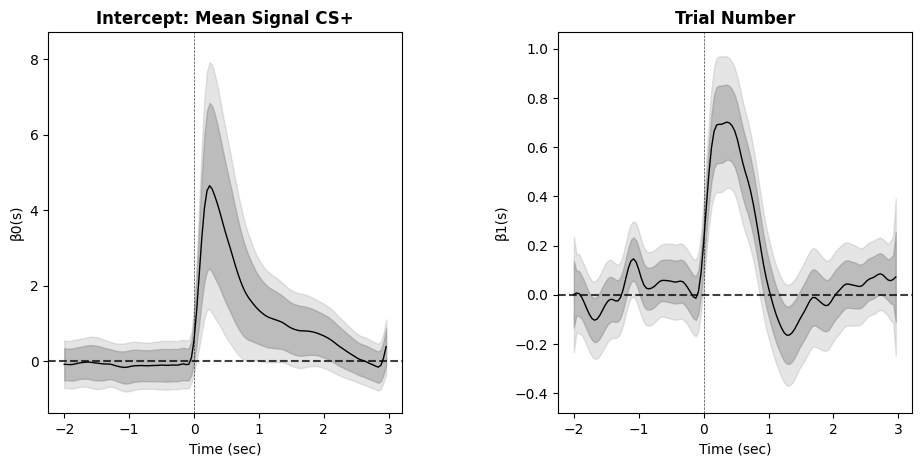

In [8]:
# plot model with best model fit (AIC/BIC)
figure = plot_fui(mod1, 
         xlab = "Time (sec)", # label x-axis
         x_rescale = 25, # rescale x-axis to be in sec - photometry sampled at 25 Hz 
         align_x = 2, # align to time of cue onset
         title_names = ["Intercept: Mean Signal CS+", "Trial Number"]
         )
figure.set_size_inches(10, 5)


We fit a simple model where $\texttt{trial}$ number is the only covariate using a dataset containing only CS+ trials. Recall that the functional intercept, $\beta_0(s)$ has the interpretation as "the mean signal (at each trial timepoint) when all covariates are 0." We modified the variable $\texttt{trial}$ to take on the value 0 on the first trial of each session. Thus, $\widehat{\beta}_0(s)$ has the interpretation as "the mean photometry signal on the first CS+ trial of every session." We can see that it is significantly greater than 0 for $\sim 1$ sec after cue onset. Since this dataset includes only sessions after substantial training, this result is expected. 

In contrast to Part I and Part II, our intercept is interpreted within a model that adopts a linear term for $\texttt{trial}$. Thus, our intercept may not be numerically equivalent to taking the sample average of the photometry signals recorded on the first trial of every session. Although the $\beta_0(s)$ estimate has the interpretation described above, just remember that we are adopting a simple (linear) model for the effect of $\texttt{trial}$ on the photometry signal and this in turns influences the estimates for $\beta_0(s)$. 

The $\widehat{\beta}_1(s)$ coefficient estimate is interpreted as "the mean change in the photometry signal for a 1 unit change in the $\texttt{trial}$ number variable at trial timepoint $s$." Since we rescaled the $\texttt{trial}$ number variable to range between 0 and 1 (where it takes on the value 1 on the last trial of the session), this $\widehat{\beta}_1(s)$ plot has the interpretation as "the mean change in the photometry signal from the first to the last CS+ trial of each session at trial timepoint $s$." Since the 95% CIs do not contain 0 between 0-1sec,  there is a statistically significant increase in the mean photometry signal across trials within-session during the first second of the CS+. 

Like a correlation, this model places linear structure on the $\texttt{trial}$--signal relationship. Some statisticians prefer to use the term "linear projection" to emphasize that we might not know whether the relationship is actually linear (e.g., if had we recorded 10000 trials, do we $really$ think the signal would just keep rising indefinitely at the same rate?), but we are looking at the best linear fit to this data.

## Functional Slope Interpretation

The reason the functional slope has the interpretation as "the mean change in the photometry signal for a 1 unit change in the covariate at trial timepoint $s$" can be seen through algebraic steps similar to what we saw in Part I. We start by writing down an expression with the the above interpretation: $\mathbb{E}[Y_{ij}(s) \mid X_{ij} = x + 1] - \mathbb{E}[Y_{ij}(s) \mid X_{ij} = x]$, where $\mathbb{E}[Y_{ij}(s) \mid X_{ij} = x]$ can be read as, "the mean photometry value, for animal $i$, on trial $j$ at timepoint $s$ when $\texttt{trial} = x$" and $x$ is some arbitrary value. Thus, the equation above is actually just algebraically expressing "the mean change in the signal from a 1 unit change in $\texttt{trial}$ number." When we plug in our model, our expression simplifies to

$$
\begin{align} 
&\mathbb{E}[Y_{ij}(s) \mid X_{ij} = x + 1] - \mathbb{E}[Y_{ij}(s) \mid X_{ij} = x] \\
&=\beta_0(s) + (x + 1){\beta}_1(s)  - \left [ \beta_0(s) + x \beta_1(s) \right ] \\
&=\beta_1(s).
\end{align} 
$$
This shows why our $\beta_1(s)$ estimates, $\widehat{\beta}_1(s)$, have the above interpretation.

Keep in mind that when models contain more than one covariate, we have to modify our interpretation to be conditional on all other variables in the model. In practice, this means our interpretations include the phrase "...holding all other covariates constant." Some statisticians prefer the language "...when all other covariates happen to have the same value," to avoid any implication of causal effects (since we did not experimentally set the other covariates to have the same value).

### General Interpretation Suggestions

Remember, as we saw in Parts I-III, interpretations for the intercept and the scale of the functional slopes will depend on any pre-processing or modifications to the covariates in the model (or what trials/observations are included). Here we used a couple simple tricks like modifying our $\texttt{trial}$ number variable to equal 0 on the first trial of each session, and scaling it so that the variable takes on the value 1 on the last trial of each session. This in turn translated to a convenient interpretation for both the ${\beta}_0(s)$ and ${\beta}_1(s)$ coefficient estimates. Normalizing (centering and scaling) covariates is also a common strategy since this ensures the intercept (in univariate models) has the interpretation as the mean signal when the covariate takes on its average value. It also translates the "1 unit change in the covariate" to be in terms of a "1 standard deviation change in the covariate", allowing for coefficient estimate interpretations to be on a scale that are independent of the units of the original covariate.

Figure 2B of our paper, [Loewinger et al., 2024](https://elifesciences.org/reviewed-preprints/95802), illustrates how to conceptualize the ${\beta}_1(s)$ coefficient estimates (the functional fixed effect of a continuous covariate) as well as the functional random effect of a continuous covariate.


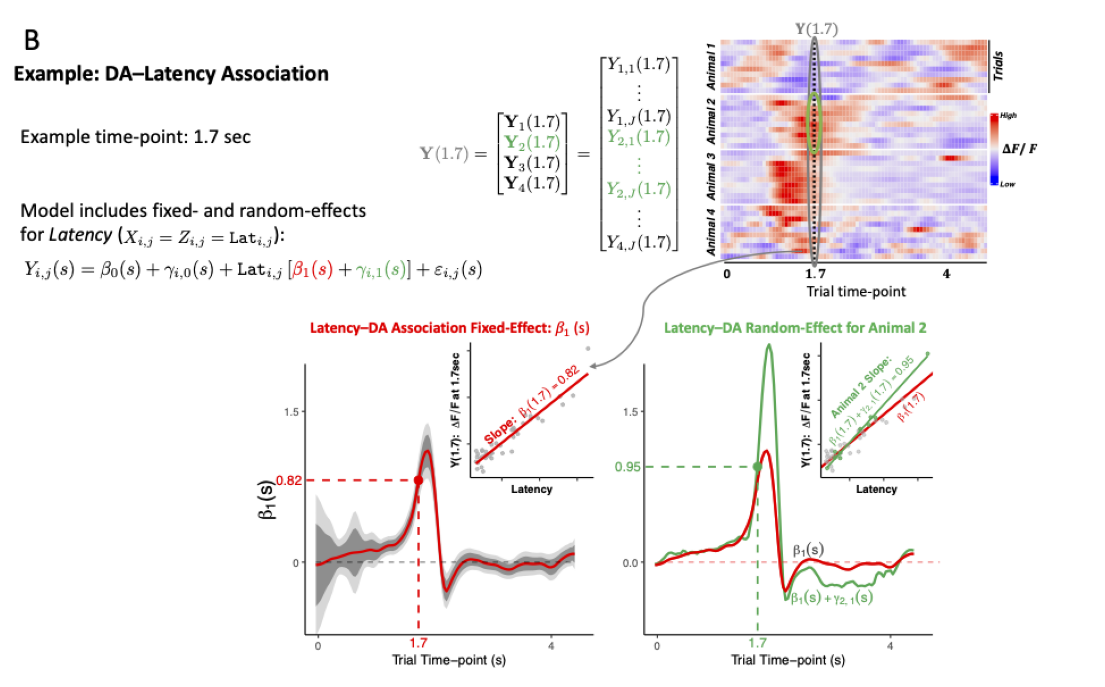

In [9]:
image = plt.imread(r"fLME_explanation PDF B.png")
plt.axis("off")
ax = plt.imshow(image)
ax.figure.set_size_inches(14, 14)


# Pointwise or Joint 95% Confidence Intervals
We recommend basing inference off of joint CIs for two reasons: interpretability and multiple comparisons corrections. Joint CIs identify $intervals$ of the trial during which the effects are significant, while pointwise identify individual timepoints that are significant. Typically analyst are more interested in time intervals and so we argue joint CIs are more interpretable in photometry analyses. Joint CIs also provide an adjustment for the multiple comparisons of inspecting effects along the entire trial. It is reasonable to report both types of CIs, but we recommend basing conclusions off of joint CIs in most situations.

# How to Cite
For use of this package or vignette, please cite the following papers:

Gabriel Loewinger, Erjia Cui, David Lovinger, and Francisco Pereiera. [A Statistical Framework for Analysis of Trial-Level Temporal Dynamics in Fiber Photometry Experiments](https://elifesciences.org/reviewed-preprints/95802). eLife (2024).

Erjia Cui, Andrew Leroux, Ekaterina Smirnova, and Ciprian Crainiceanu. [Fast Univariate Inference for Longitudinal Functional Models](https://doi.org/10.1080/10618600.2021.1950006). Journal of Computational and Graphical Statistics (2022).

# References

Doug Bates. [lme4: Mixed-effects modeling with R](https://stat.ethz.ch/~maechler/MEMo-pages/lMMwR.pdf) (2022).

Huijeong Jeong, Annie Taylor, Joseph Floeder, Martin Lohmann, Stefan Mihalas, Brenda Wu, Mingkang Zhou, Dennis Burke, Vijay Namboodiri. [Mesolimbic dopamine release conveys causal associations.](https://www.science.org/doi/full/10.1126/science.abq6740) Science 378, 6740 (2022).